This notebook contains the all the ACO implention and experiments on the Brazil dataset 

In [1]:
import xml.etree.ElementTree as ET
import random
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import networkx as nx


Read Brazil data 

In [3]:
tree = ET.parse('brazil58.xml')
root = tree.getroot()
num_vertices = len(root.findall('.//vertex'))
costs_ = [[0.0] * num_vertices for _ in range(num_vertices)]

count_vertex = 0
for vertex in root.findall('.//vertex'):
    source_id = count_vertex

    for edge in vertex.findall('edge'):
        target_id = int(edge.text)
        cost = float(edge.get('cost'))
        costs_[source_id - 1][target_id - 1] = cost  # Adjust indices since IDs start from 1
       
    count_vertex += 1
    
distances = costs_

Code for Ant Colony Optimization (ACO)

In [6]:
import random 

# Function to initialize pheromone levels on edges
def initialize_pheromones(num_vertices):
    return [[1.0] * num_vertices for r in range(num_vertices)]

# Function to choose the next city based on pheromone levels and distances
def choose_next_city(current_city, allowed_cities, pheromones, distances, alpha=1.0, beta=2.0):
    allowed_cities_list = list(allowed_cities)
    pheromone_values = [
        pheromones[current_city][city] ** alpha * (1.0 / distances[current_city][city]) ** beta
        for city in allowed_cities_list
    ]
    total = sum(pheromone_values)
    probabilities = [value / total for value in pheromone_values]
    chosen_city = random.choices(allowed_cities_list, probabilities)[0]
    return chosen_city


# Function to update pheromone levels based on ant paths
def update_pheromones(pheromones, ant_paths, e=0.3, Q=1.0):
    for fitness, path in ant_paths:
        pheromone_increment = Q / fitness
        for i in range(len(path) - 1):
            pheromones[path[i]][path[i + 1]] = (1.0 - e) * pheromones[path[i]][path[i + 1]] + pheromone_increment

# Ant Colony Optimization algorithm
def ACO(colony_size, num_iterations, distances, alpha=1.0, beta=2.0, e=0.3, Q=1.0):
        
    num_vertices = len(distances)
    pheromones = initialize_pheromones(num_vertices)

    global_best_path = None
    global_best_cost = float('inf')

    for iteration in range(num_iterations):
        ant_paths = []

        for ant in range(colony_size):
            current_city = random.randint(0, num_vertices - 1)
            allowed_cities = set(range(num_vertices))
            allowed_cities.remove(current_city)
            path = [current_city]
            fitness = 0.0

            while allowed_cities:
                next_city = choose_next_city(current_city, allowed_cities, pheromones, distances, alpha, beta)
                fitness += distances[current_city][next_city]
                path.append(next_city)
                allowed_cities.remove(next_city)
                current_city = next_city

            fitness += distances[path[-1]][path[0]]  # Complete the cycle
            ant_paths.append((fitness, path))

            if fitness < global_best_cost:
                global_best_cost = fitness
                global_best_path = path

        update_pheromones(pheromones, ant_paths, e, Q)

        return global_best_path, global_best_cost
        

In [7]:
distances = costs_
colony_sizes = [10, 50, 100]
evap_rates = [0.3, 0.6, 0.9]
num_iterations = 10000 #Will only run 10000 times

# Create dictionaries to store results
best_paths = {size: [] for size in colony_sizes}
best_costs = {size: [] for size in colony_sizes}

for rates in evap_rates:
    for i in colony_sizes :
        optimal_path, optimal_cost = ACO(i, num_iterations, distances, alpha=1.0, beta=2.0, e= rates, Q=1.0)
        # Store the results in the dictionaries
        best_paths[i].append(optimal_path)
        best_costs[i].append(optimal_cost)

index = [ 'Evaporation Rate 0.3', 'Evaporation Rate 0.6', 'Evaporation Rate 0.9']

df1 = pd.DataFrame(best_costs)
df1.set_index(pd.Index(index), inplace=True)
df1.rename(columns={10: 'Colony_Size_10', 50: 'Colony_Size_50', 100: 'Colony_Size_100'}, inplace = True)

                      Colony_Size_10  Colony_Size_50  Colony_Size_100
Evaporation Rate 0.3         49779.0         43483.0          43308.0
Evaporation Rate 0.6         44141.0         44368.0          37980.0
Evaporation Rate 0.9         50053.0         42917.0          43127.0


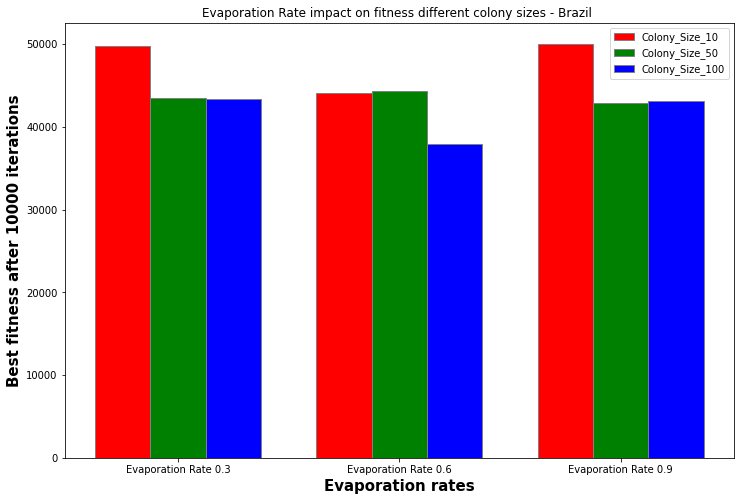

In [18]:
print(df1)
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
  
# Set position of bar on X axis 
br1 = np.arange(3) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, df1['Colony_Size_10'], color ='r', width = barWidth, 
        edgecolor ='grey', label ='Colony_Size_10') 
plt.bar(br2, df1['Colony_Size_50'], color ='g', width = barWidth, 
        edgecolor ='grey', label ='Colony_Size_50') 
plt.bar(br3, df1['Colony_Size_100'], color ='b', width = barWidth, 
        edgecolor ='grey', label ='Colony_Size_100') 
 
# Adding Xticks 
plt.xlabel('Evaporation rates', fontweight ='bold', fontsize = 15) 
plt.ylabel('Best fitness after 10000 iterations', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(3)], 
        ['Evaporation Rate 0.3', 'Evaporation Rate 0.6', 'Evaporation Rate 0.9'])
plt.title('Evaporation Rate impact on fitness different colony sizes - Brazil ') 
plt.legend()
plt.show() 

Code for MMAS Ant Colony Optimisation

In [10]:
def initialize_pheromones(distances, initial_pheromone=1.0):
    pheromones = np.full_like(distances, initial_pheromone)
    np.fill_diagonal(pheromones, 0)  # Set pheromones on the diagonal to 0
    return pheromones

def ant_colony(distances, colony_sizes, alpha, beta, rho, q):
    pheromones = initialize_pheromones(distances)
    best_path = None
    fitness = float('inf')

    for r in range(colony_sizes):
        ant_path, ant_cost = construct_solution(distances, pheromones, alpha, beta)
        if ant_cost < fitness:
            best_path = ant_path
            fitness = ant_cost

        update_pheromones(pheromones, ant_path, ant_cost, rho, q)

    return best_path, fitness

def construct_solution(distances, pheromones, alpha, beta):
    start = np.random.choice(len(distances))
    visited = set([start])
    path = [start]
    cost = 0

    while len(visited) < len(distances):
        next_city = choose_next_city(distances, pheromones, path[-1], visited, alpha, beta)
        path.append(next_city)
        visited.add(next_city)
        cost += distances[path[-2]][path[-1]]

    cost += distances[path[-1]][path[0]]
    return path, cost

def choose_next_city(distances, pheromones, current_city, visited, alpha, beta):
    unvisited_cities = set(range(len(distances))) - visited
    probabilities = calculate_probabilities(distances, pheromones, current_city, unvisited_cities, alpha, beta)
    next_city = np.random.choice(list(unvisited_cities), p=probabilities)
    return next_city

def calculate_probabilities(distances, pheromones, current_city, unvisited_cities, alpha, beta):
    probabilities = []
    total_pheromone = 0

    for city in unvisited_cities:
        pheromone = pheromones[current_city][city]
        visibility = 1 / distances[current_city][city]
        total_pheromone += (pheromone ** alpha) * (visibility ** beta)

    for city in unvisited_cities:
        pheromone = pheromones[current_city][city]
        visibility = 1 / distances[current_city][city]
        probability = (pheromone ** alpha) * (visibility ** beta) / total_pheromone
        probabilities.append(probability)

    return probabilities

def update_pheromones(pheromones, path, cost, rho, q):
    if cost == 0:
        # Handle the case where the cost is zero to prevent division by zero
        return

    pheromone_deposit = q / cost

    for i in range(len(path) - 1):
        if cost != 0:
            pheromones[path[i]][path[i + 1]] = (1 - rho) * pheromones[path[i]][path[i + 1]] + rho * pheromone_deposit

    if cost != 0: 
        pheromones[path[-1]][path[0]] = (1 - rho) * pheromones[path[-1]][path[0]] + rho * pheromone_deposit


def mmas_aco(distances, colony_sizes, num_iterations, alpha, beta, rho, q):
    best_path = None
    fitness = float('inf')

    for _ in range(num_iterations):
        path, cost = ant_colony(distances, colony_sizes, alpha, beta, rho, q)
        if cost < fitness:
            best_path = path
            fitness = cost

    return best_path, fitness

MMAS will take ~2.5 hours to run 

In [11]:
colony_sizes = [10, 50, 100]
num_iterations = 10000

best_paths_mms = {size: [] for size in colony_sizes}
best_costs_mms = {size: [] for size in colony_sizes}


for i in colony_sizes :
    optimal_path, optimal_cost = mmas_aco(distances, i, num_iterations, alpha=1.0, beta=2.0,rho = 0.3, q=1)
    # Store the best results in the dictionaries
    best_paths_mms[i].append(optimal_path)
    best_costs_mms[i].append(optimal_cost)

index = [ 'Evaporation Rate 0.3', 'Evaporation Rate 0.6', 'Evaporation Rate 0.9']



In [12]:
key_changes = {10: 'Colony_Size_10', 50: 'Colony_Size_50', 100: 'Colony_Size_100'}

# Create a new dictionary with updated keys
best_costs_mms = {key_changes.get(k, k): v for k, v in best_costs_mms.items()}

original_2d_list = best_costs_mms.values()

# Flatten the 2D list into a 1D list using list comprehension
flat_list = [value for sublist in original_2d_list for value in sublist]

value_changes = {'Colony_Size_10':flat_list[0],'Colony_Size_50': flat_list[1],'Colony_Size_100': flat_list[2]}

# Update values in the original dictionary
for key, new_value in value_changes.items():
    if key in best_costs_mms:
        best_costs_mms[key] = new_value

data = best_costs_mms

{'Colony_Size_10': 34992.0, 'Colony_Size_50': 34259.0, 'Colony_Size_100': 36116.0}


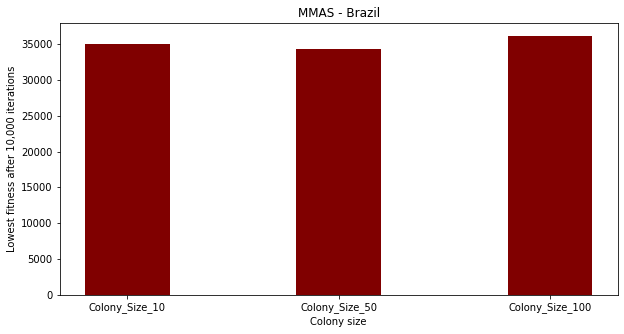

In [19]:
print(data)

courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(courses, values, color ='maroon', 
        width = 0.4)

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5, 
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey') 
    
plt.xlabel("Colony size")
plt.ylabel("Lowest fitness after 10,000 iterations")
plt.title("MMAS - Brazil")
plt.show()

Elitist Ant Colony Optimization 

In [14]:
def initialize_pheromones(distnaces, initial_pheromone=1.0):
    pheromones = np.full_like(distances, initial_pheromone)
    np.fill_diagonal(pheromones, 0)  # Set pheromones on the diagonal to 0
    return pheromones

def E_ACO(distances, colony_size, alpha, beta, rho, q, elite_percentage):
    pheromones = initialize_pheromones(distances)
    elite_ants = int(elite_percentage * colony_size)

    best_path = None
    fitness = float('inf')

    for iteration in range(num_iterations):
        ant_path, ant_cost = construct_solution(distances, pheromones, alpha, beta)
        if ant_cost < fitness:
            best_path = ant_path
            fitness = ant_cost

        update_pheromones(pheromones, ant_path, ant_cost, rho, q)

        # Apply elitism only if there are elite ants
        if elite_ants > 0:
            elite_paths = get_elite_paths(distances, pheromones, elite_ants, alpha, beta)
            if elite_paths:
                update_pheromones(pheromones, elite_paths, 0, rho, q)

    return best_path, fitness

def get_elite_paths(distances, pheromones, elite_ants, alpha, beta):
    elite_paths = []
    for elite in range(elite_ants):
        ant_path, _ = construct_solution(distances, pheromones, alpha, beta)
        elite_paths.append(ant_path)
    return elite_paths

# The rest of the code is the same as the MMAS ACO implementation

Elite ACO takes ~1.8 hours to run

In [15]:
num_ants = [10, 50, 100]
d_num_ants3 = {"10": [], "50": [], "100": []}
elite_percentage = [0.1,0.3,0.5]
num_iterations = 10000


for e in elite_percentage:
    for i in num_ants:
        best_path, best_cost = E_ACO(distances, i, alpha=1.0, beta=2.0, rho=0.3, q=1, elite_percentage= e)
        d_num_ants3[str(i)].append(best_cost)

data3 = d_num_ants3

In [16]:
index_e = ['Elite percantage 0.1','Elite percantage 0.3', 'Elite percantage 0.5']

df3 = pd.DataFrame(data3)
df3.set_index(pd.Index(index_e), inplace=True)
df3.rename(columns={'10': 'Colony_Size_10', '50': 'Colony_Size_50', '100': 'Colony_Size_100'}, inplace = True)

                      Colony_Size_10  Colony_Size_50  Colony_Size_100
Elite percantage 0.1         36222.0         36546.0          35340.0
Elite percantage 0.3         37041.0         35418.0          36989.0
Elite percantage 0.5         34351.0         37901.0          36885.0


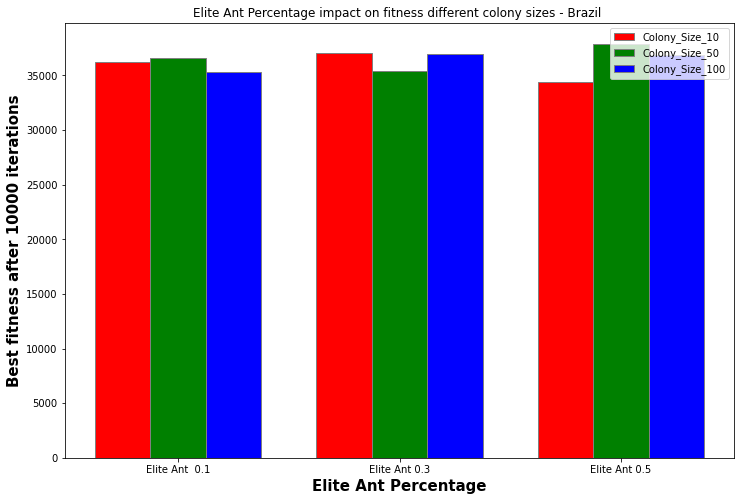

In [20]:
print(df3)

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
  
# Set position of bar on X axis 
br1 = np.arange(3) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
plt.bar(br1, df3['Colony_Size_10'], color ='r', width = barWidth, 
        edgecolor ='grey', label ='Colony_Size_10') 
plt.bar(br2, df3['Colony_Size_50'], color ='g', width = barWidth, 
        edgecolor ='grey', label ='Colony_Size_50') 
plt.bar(br3, df3['Colony_Size_100'], color ='b', width = barWidth, 
        edgecolor ='grey', label ='Colony_Size_100') 
 
# Adding Xticks 
plt.xlabel('Elite Ant Percentage', fontweight ='bold', fontsize = 15) 
plt.ylabel('Best fitness after 10000 iterations', fontweight ='bold', fontsize = 15) 
plt.xticks([r + barWidth for r in range(3)], 
        ['Elite Ant  0.1', 'Elite Ant 0.3', 'Elite Ant 0.5'])
plt.title('Elite Ant Percentage impact on fitness different colony sizes - Brazil ') 
plt.legend()
plt.show() 